# <center> Deep knowledge tracing (DKT)

### Background:

Bayesian knowledge tracing is the most popular approach to model knowledge state of learners: e.g. whether some knowledge, skills or contexts are mastery or not. BKT models a learner’s latent knowledge state as a set of binary variables, each of which represents understanding or non-understanding of a single concept. The original model formulation assumed that once a skill is learned it is never forgotten. Recent extensions to this model include contextualization of guessing and slipping estimates, estimating prior knowledge for individual learners, and estimating problem difficulty.

With or without such extensions, Knowledge Tracing suffers from several difficulties. First, the binary representation of student understanding may be unrealistic. Second, the meaning of the hidden variables and their mappings onto exercises can be ambiguous, rarely meeting the model’s expectation of a single concept per exercise. Several techniques have been developed to create and refine concept categories and concept-exercise mappings. The current gold standard, Cognitive Task Analysis is an arduous and iterative process where domain experts ask learners to talk through their thought processes while solving problems. Finally, the binary response data used to model transitions imposes a limit on the kinds of exercises that can be modeled.

Recurrent Neural Networks (RNNs) to model student learning has been explored by the paper: Deep knowledge tracing. The RNN family of models has important advantages over previous methods in that they do not require the explicit encoding of human domain knowledge, and can capture more complex representations of student knowledge. Using neural networks results in substantial improvements in prediction performance on a range of knowledge tracing datasets. Moreover, the learned model can be used for intelligent curriculum design and allows straightforward interpretation and discovery of structure in student tasks. These results suggest a promising new line of research for knowledge tracing and an exemplary application task for RNNs.


### Methodology
#### Recurrent Neural Networks
Traditional Recurrent Neural Networks (RNNs) map an input sequence of vectors $x_1,x_2,…,x_T$, to an output sequence of vectors$y_1,y_2,…,y_T$. This is achieved by computing a sequence of ‘hidden’ states $h_1,h_2,…,h_T$ which can be viewed as successive encodings of relevant information from past observations that will be useful for future predictions. See the figure below for a cartoon illustration. The variables are related using a simple network defined by the equations:
                                    
$$h_t=tanh⁡(W_{hx} x_t+W_{hh} h_{t-1}+b_h )\\
y_t = \sigma(W_{yh} h_t+b_y  )$$
where both tanh and the sigmoid function, $\sigma(\cdot)$, are applied elementwise. The model is parameterized by an input weight matrix $W_{hx}$, recurrent weight matrix $W_{hh}$, initial state $h_0$, and readout weight matrix W_yh. Biases for latent and readout units are given by $b_h$  and $b_y$. 
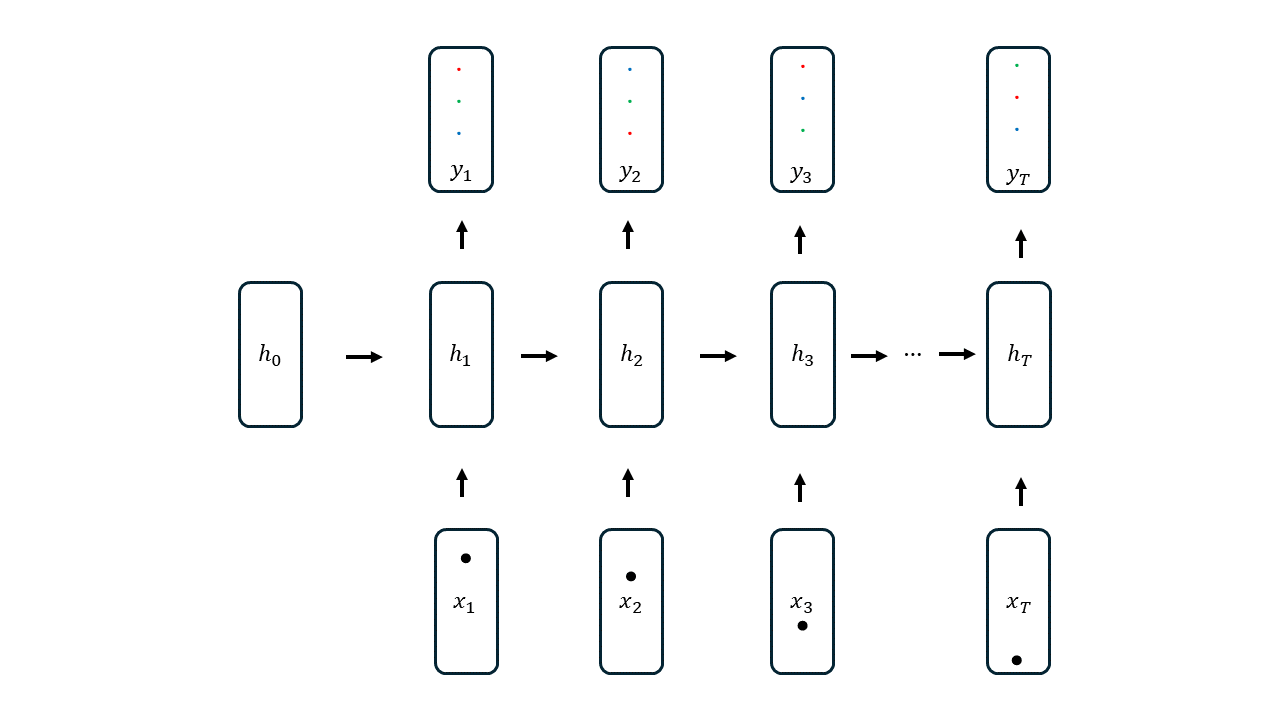


#### Input and Output
##### One-hot encoding input
In order to train an RNN or LSTM on student interactions, it is necessary to convert those interactions into a sequence of fixed length input vectors $x_t$.  We transform the question numbers and corresponding response into one-hot encodings.  For instance, we have three questions 1,2,3 with the corresponding response 0, 1,1 (0 means not correct and 1 means correct).  
1 2 3
0 1 1
Then the questions with corresponding responses can be transformed into 000 100, 010 000, 001 000. Each one-hot encoding dimension is double size of the max question number. The questions starts from 1 (the largest question number is 3 in the above example and the dimension of one-hot encoding is 3*2: see 000 100). If a question is answered correctly, then ‘1’ will assigned in the first 3 digitals, otherwise, it is assigned in the last 3 digitals. 
The input is [[000 100], [010 000], [001 000]].

##### Embedding input
In the above example, the questions with the responses are transformed into one-hot encodings, which are easy to understand. However, in case of large number of questions, the length of the one-hot encoding is large and the input composed by the one-hot encodings is sparse. This may lead to time consuming when training RNN or LSTM models.

Instead of transforming the question numbers with responses into an one-hot encoding, we can first transform them into a integer, and then transform the integer into a embedding vector which size could be much smaller than the length of one-hot encoding. Still we consider the above example: we have three questions 1,2,3 with the corresponding response 0, 1,1 (0 means not correct and 1 means correct).  
1 2 3
0 1 1
We transform the three questions with corresponding responses as follows:
                                $$1 + 0*3 = 1$$     
                                $$2 + 1*3 = 5 $$  
                                $$3 + 1*3 = 6$$     
Then we have invertible unique numbers 1, 5, 6, which can be transformed back to the question numbers and responses. Then in the next step, we can apply Python package to transform these unique numbers to some embedding. 


#### Output
The DKT model produce the probability for mastering all the questions which may be asked in the next step:
Here is the example:

1 2 3 2 3          
0 1 0 1 1 

Then the corresponding one-hot encodings and the corresponding outputs of the DKT are 

000 100 (question 1 answered incorrect) $\hspace{0.2cm}$ $p_{11},p_{12},p_{13}$

010 000 (question 2 answered correct)  $\hspace{0.45cm}$  $p_{21},p_{22},p_{23}$  

000 001 (question 3 answered incorrect) $\hspace{0.2cm}$ $p_{31},p_{32},p_{33}$ 

010 000 (question 2 answered correct)  $\hspace{0.4cm}$   $p_{41},p_{42},p_{43}$ 

001 000 (question 3 answered correct) 

$\hspace{0.3cm}$  $p_{11}, p_{12}, p_{13}$ are the probability of answering next questions correctly when next question is question 1, question 2 or question 3 with question 1 answered incorrectly. Similarly, $p_{21}$, $p_{22}$, $p_{23}$ are the probability of answering next questions correctly when next question is question 1, question 2 or question 3 with questions 1 and 2 answered incorrectly and correctly respectively. This explanation can be extended to the case with embedding input.

In [14]:
import sys
sys.path.insert(0, "..")
import argparse
import torch
import torch.optim
from torch.utils.data import DataLoader
import pandas as pd
import logging
from functools import partial
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data.dataset import Dataset
import torch.utils.data as Data
import torchmetrics

### data preparation 

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df = pd.read_csv("data/assist2015_train.csv",header=None,sep='\t')
test_df = pd.read_csv("data/assist2015_test.csv", header=None, sep='\t')
train_len = len(train_df)
test_len = len(test_df)

train_values = train_df[0].str.split(',').values
train_flattened_values = [item for sublist in train_values for item in sublist]
train_set = map(int,list(set(train_flattened_values)))
train_list = sorted(train_set)

test_values = test_df[0].str.split(',').values
test_flattened_values = [item for sublist in test_values for item in sublist]
test_set = map(int,list(set(test_flattened_values)))
test_list = sorted(test_set)

num_skills = len(train_list)

print(num_skills) 

100


In [16]:
def getData(df, n_skill, max_step=64):
    stus_ques = []
    stus_ans = []
    stus_ques_ans = []
    mask = []
    
    
    for i in range(len(df)):
        ques = df[0][i].split(",")
        ans = df[1][i].split(",")
        ques = list(map(int, ques))
        ans = list(map(int, ans))
        ques_ans = list(np.array(ques) + np.array(ans) * n_skill)
        
        len_list = len(ques)
        num_segments = (len_list + max_step - 1) // max_step  # Calculate number of segments more efficiently
         
        
        for j in range(num_segments):
            start_idx = j * max_step
            end_idx = min((j + 1) * max_step, len_list)

            segment_ques = ques[start_idx:end_idx] + [n_skill] * (max_step - (end_idx - start_idx))  
            segment_ans = ans[start_idx:end_idx] + [-1] * (max_step - (end_idx - start_idx))  
            segment_ques_ans = ques_ans[start_idx:end_idx-1] + [n_skill * 2]* (max_step - (end_idx - start_idx)+1)
            segment_mask = list(np.ones((end_idx-start_idx))) + [0]* (max_step - (end_idx - start_idx))
            
            stus_ques.append(segment_ques)
            stus_ans.append(segment_ans)
            stus_ques_ans.append(segment_ques_ans)
            mask.append(segment_mask)
    
    return np.array(stus_ques), np.array(stus_ans), np.array(stus_ques_ans), np.array(mask)

In [17]:
%%time
train_ques, train_ans, train_ques_ans, train_mask = getData(train_df,100,max_step = 64)
test_ques, test_ans, test_ques_ans, test_mask = getData(test_df,100,max_step = 64)

Wall time: 2.14 s


In [18]:
class DKTDataSet(Dataset):
    def __init__(self,ques,ans,ques_ans,mask,num_skill,max_step=64):
        self.ques = ques
        self.ans = ans
        self.ques_ans = ques_ans
        self.mask = mask
        self.num_skill = num_skill

    def __len__(self):
        return len(self.ques)    
    
    def __getitem__(self, index):
        qu_ids = torch.LongTensor(self.ques[index])
        an_resps = self.ans[index]
        qu_resps = self.ques_ans[index]
        mask_res = self.mask[index]
         
        return (
            torch.cat((torch.LongTensor([2 * self.num_skill]), torch.LongTensor(qu_resps[:-1]))),
            qu_ids.view(-1, 1),
            torch.LongTensor(an_resps),
            torch.LongTensor(mask_res),
        )

    

### model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# -*- coding:utf-8 -*-
"""
    Paper reference: Deep Knowledge Tracing (https://arxiv.org/abs/1506.05908)
"""

import torch
import torch.nn as nn


class DKT(nn.Module):
    def __init__(self,embed_dim,input_dim,hidden_dim,layer_num,output_dim,dropout,device="cpu",cell_type="lstm"):
    
        super(DKT, self).__init__()
        self.embed_dim = embed_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_num = layer_num
        self.output_dim = output_dim + 1
        self.dropout = dropout
        self.device = device
        self.cell_type = cell_type
        self.rnn = None

        self.skill_embedding = nn.Embedding(self.input_dim, self.embed_dim, padding_idx=self.input_dim - 1)

        if cell_type.lower() == "lstm":
            self.rnn = nn.LSTM(self.embed_dim,self.hidden_dim,self.layer_num,batch_first=True,dropout=self.dropout)
        elif cell_type.lower() == "rnn":
            self.rnn = nn.RNN(self.embed_dim,self.hidden_dim,self.layer_num,batch_first=True,dropout=self.dropout)
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)


    def forward(self,   ques_ans, state_in=None):

        ques_ans = self.skill_embedding(ques_ans)
        h0 = torch.zeros((self.layer_num, ques_ans.size(0), self.hidden_dim), device=self.device)
        c0 = torch.zeros((self.layer_num, ques_ans.size(0), self.hidden_dim), device=self.device)

        if state_in is None:
            state_in = (h0, c0)

        state, state_out = self.rnn(ques_ans, state_in)
        logits = self.fc(state)
        return logits, state_out

### loss function definition

In [21]:
# -*- coding:utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional


class DKTLoss(nn.Module):
    def __init__(self):
        super(DKTLoss, self).__init__()
         

    def forward(self, logits, ans, qu_ids, mask, device="cpu"):
        preds = torch.sigmoid(logits)
         
        preds = torch.gather(preds, dim=2, index=qu_ids)
         
        preds = torch.squeeze(preds)
        preds_ex_1st_col = preds[:,1:]
        
        ans_ex_1st_col = ans[:,1:]
        
        ones = torch.ones(ans.size(), device=device)
        ones_ex_1st_col = ones[:,1:]
        mask_ex_1st_col = mask[:,1:]
        
        total = torch.sum(mask) + 1
        loss = -torch.sum(
            mask_ex_1st_col * ans_ex_1st_col * torch.log(preds_ex_1st_col)
            + mask_ex_1st_col * (ones_ex_1st_col - ans_ex_1st_col) * torch.log(ones_ex_1st_col - preds_ex_1st_col)
        )

         
        loss = loss / total

         

        return loss
    
    
    

 

### training and evalution function

In [22]:
import torch
from sklearn.metrics import (roc_auc_score,precision_recall_fscore_support,accuracy_score)
import numpy as np
import os
import random


def train_epoch(model, train_iterator, optim, criterion, device="cpu"):
    model.train()

    for i, (ques_ans, ques_id, labels, mask) in enumerate(train_iterator):
        ques_ans, ques_id, labels, mask = (ques_ans.to(device),ques_id.to(device),labels.to(device),mask.to(device))
        
        optim.zero_grad()
        logits, _ = model(ques_ans)
        loss = criterion(logits, labels, ques_id, mask, device=device)
        loss.backward()
        optim.step()


def eval_epoch(model, test_iterator, criterion, eval_func,data_type, device="cpu"):
    model.eval()

    eval_loss = []
    preds, binary_preds, targets = [], [], []
    for i, (ques_ans, ques_id, labels, mask) in enumerate(test_iterator):
        ques_ans, ques_id, labels, mask = (ques_ans.to(device),ques_id.to(device),labels.to(device),mask.to(device))

        with torch.no_grad():
            logits, _ = model(ques_ans)

        loss = criterion(logits, labels, ques_id, mask, device=device)
        eval_loss.append(loss.detach().item())

        mask = mask.eq(1)
        
        
        pred, binary_pred, target = eval_func(logits, ques_id, labels, mask)
        preds.append(pred)
        binary_preds.append(binary_pred)
        targets.append(target)

    preds = np.concatenate(preds)
    binary_preds = np.concatenate(binary_preds)
    targets = np.concatenate(targets)

    auc_value = roc_auc_score(targets, preds)
    accuracy = accuracy_score(targets, binary_preds)
    precision, recall, f_score, _ = precision_recall_fscore_support(
        targets, binary_preds
    )
    pos_rate = np.sum(targets) / float(len(targets))
    print(data_type,
        "auc={0}, accuracy={1}, precision={2}, recall={3}, fscore={4}, pos_rate={5}".format(
            auc_value, accuracy, precision, recall, f_score, pos_rate
        )
    )
    return auc_value


def dkt_predict(logits, ques_id):
    preds = torch.sigmoid(logits)
    preds = torch.gather(preds, dim=2, index=ques_id)
    preds = torch.squeeze(preds)
    binary_preds = torch.round(preds)
    return (
        preds.view(preds.size()[0], preds.size()[1]),
        binary_preds.view(preds.size()[0], preds.size()[1]),
    )    
    
def dkt_eval(logits, ques_id, targets, mask):
    pred, binary_pred = dkt_predict(logits, ques_id)
    pred_ex_1st_col = pred[:,1:]
    binary_pred_ex_1st_col = binary_pred[:,1:] 
    mask_ex_1st_col = mask[:,1:]
    targets_ex_1st_col = targets[:,1:]
    pred = torch.masked_select(pred_ex_1st_col, mask_ex_1st_col).detach().numpy()
    binary_pred = torch.masked_select(binary_pred_ex_1st_col, mask_ex_1st_col).detach().numpy()
    target = torch.masked_select(targets_ex_1st_col, mask_ex_1st_col).detach().numpy()
    return pred, binary_pred, target

 

### code running

In [23]:

def run(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train = DKTDataSet(train_ques, train_ans, train_ques_ans, train_mask,100)
     
     
    test = DKTDataSet(test_ques, test_ans, test_ques_ans, test_mask,100)
    
    
    train_dataloader = DataLoader(train,batch_size=args.batch_size,num_workers=args.num_worker,shuffle=True)
    
    
    test_dataloader = DataLoader(test,batch_size=args.batch_size*2,num_workers=args.num_worker,shuffle=False)

    dkt = DKT(args.embed_dim,
              args.num_skill * 2 + 1,
              args.hidden_dim,
              args.layer_num,
              args.num_skill,
              args.dropout,
              device=device)
    optimizer = torch.optim.Adam(dkt.parameters(), lr=args.learning_rate)
    loss_func = DKTLoss()

    dkt.to(device)
    loss_func.to(device)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    over_fit = 0
    last_auc = 0
    for epoch in range(args.epoch):
        train_epoch(dkt, train_dataloader, optimizer, loss_func,device)
        print('-------------------------------------------------------------------------------')
        print('-------------------------------------------------------------------------------')
#         data_type = 'train_data'
#         eval_epoch(dkt, train_dataloader, loss_func, dkt_eval,data_type, device)
#         print('-------------')
        data_type = 'test_data'
        auc_value = eval_epoch(dkt, test_dataloader, loss_func, dkt_eval,data_type, device)
        scheduler.step()
#         if auc_value > last_auc:
#             last_auc = auc_value
#             over_fit = 0
#         else:
#             over_fit += 1


#         if over_fit >= 2:
#             print("early stop epoch ", epoch)
#             break
        
        





In [ ]:
%%time
arg_parser = argparse.ArgumentParser(description="train dkt model")
arg_parser.add_argument("--learning_rate",dest="learning_rate",default=0.001,type=float,required=False)
arg_parser.add_argument("--batch_size",dest="batch_size",default=64,type=int,required=False)
arg_parser.add_argument("--num_skill",dest="num_skill",default=num_skills,type=int,required=False)
arg_parser.add_argument("--embed_dim",dest="embed_dim",default=100,type=int,required=False)
arg_parser.add_argument("--hidden_dim",dest="hidden_dim",default=100,type=int,required=False)
arg_parser.add_argument("--layer_num",dest="layer_num",default=1,type=int,required=False)
arg_parser.add_argument("--output_dim",dest="output_dim",default=100,type=int,required=False)
arg_parser.add_argument("--dropout",dest="dropout",default=0.0,type=float,required=False)
arg_parser.add_argument("--cell_type",dest="cell_type",default="lstm",type=str,required=False)
arg_parser.add_argument("--epoch",dest="epoch",default=10,type=int,required=False)
arg_parser.add_argument("--num_worker",dest="num_worker",default=0,type=int,required=False)

args,unknown_args = arg_parser.parse_known_args()
run(args)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
test_data auc=0.723840185234873, accuracy=0.754836831176394, precision=[0.57490953 0.77378593], recall=[0.21114032 0.94530781], fscore=[0.30885212 0.85099011], pos_rate=0.7405619535817454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
test_data auc=0.7278529462594236, accuracy=0.7551050119148871, precision=[0.56924985 0.77691024], recall=[0.23039664 0.93892395], fscore=[0.32802809 0.85026821], pos_rate=0.7405619535817454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
test_data auc=0.7294936047358811, accuracy=0.7561930594824878, precision=[0.58504252 0.7735139 ], recall=[0.2072418  0.94850491], fscore=[0.30